<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#                                   Pneumonia Detection
![Pneumonia](https://www.drugs.com/health-guide/images/022dc126-fc5d-4e54-9a78-75f2c9ea4bb6.jpg)
## Problem Interpretation:
   The goal is to build a pneumonia detection system, to locate the position of inflammation in an chest radiograph (CXR) image. With sparse material, such as lungs which are full of air, do not absorb the X-rays and appear black in the image. Dense tissues such as bones absorb X-rays and appear white in the image.
While we are theoretically detecting “lung opacities”, there are lung opacities that are not pneumonia related.

## Data Interpretation:
  In the data, some of these are labeled **“Not Normal No Lung Opacity”**. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and often times this finding may mimic the appearance of true pneumonia.
 
## What files do I need?
  This is a two-stage challenge. You will need the images for the current stage - provided as **stage_2_train_images.zip** and **stage_2_test_images.zip**. You will also need the training data - **stage_2_train_labels.csv** - and the sample submission **stage_2_sample_submission.csv**, which provides the IDs for the test set, as well as a sample of what your submission should look like. The file **stage_2_detailed_class_info.csv** contains detailed information about the positive and negative classes in the training set, and may be used to build more nuanced models.

## What should I expect the data format to be?
  The training data is provided as a set of **patientIds** and bounding boxes. Bounding boxes are defined as follows: x-min y-min width height

There is also a binary target column, **Target**, indicating pneumonia or non-pneumonia.

There may be multiple rows per **patientId**.

## DICOM Images
  All provided images are in DICOM format. Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.

## What am I predicting?
  Here we are predicting whether pneumonia exists in a given image. They do so by predicting bounding boxes around areas of the lung. Samples without bounding boxes are negative and contain no definitive evidence of pneumonia. Samples with bounding boxes indicate evidence of pneumonia.

When making predictions, competitors should predict as many bounding boxes as they feel are necessary, in the format: confidence x-min y-min width height

There should be only ONE predicted row per image. This row may include multiple bounding boxes.

A properly formatted row may look like any of the following.

For patientIds with no predicted pneumonia / bounding boxes: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,

For patientIds with a single predicted bounding box: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.5 0 0 100 100

For patientIds with multiple predicted bounding boxes: 0004cfab-14fd-4e49-80ba-63a80b6bddd6,0.5 0 0 100 100 0.5 0 0 100 100, etc.

## File descriptions
**stage_2_train.csv** - the training set. Contains patientIds and bounding box / target information.

**stage_2_sample_submission.csv** - a sample submission file in the correct format. Contains patientIds for the test set. Note that the sample submission contains one box per image, but there is no limit to the number of bounding boxes that can be assigned to a given image.

**stage_2_detailed_class_info.csv** - provides detailed information about the type of positive or negative class for each image.
## Data fields
patientId _- A patientId. Each patientId corresponds to a unique image.

x_ - the upper-left x coordinate of the bounding box.

y_ - the upper-left y coordinate of the bounding box.

width_ - the width of the bounding box.

height_ - the height of the bounding box.

Target_ - the binary Target, indicating whether this sample has evidence of pneumonia.


## What is pneumonia?


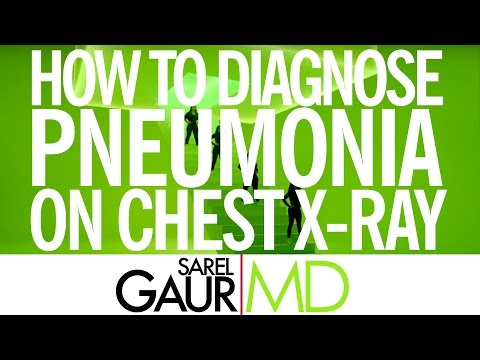

In [ ]:

import IPython
IPython.display.YouTubeVideo('mMEen0O6xwc')

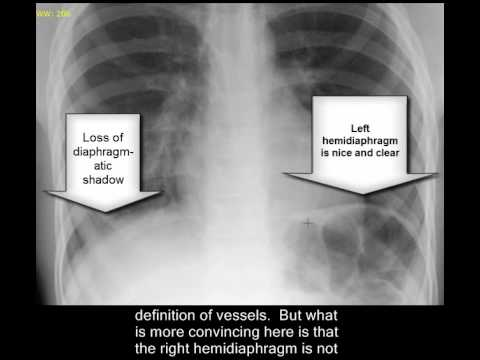

In [ ]:
IPython.display.YouTubeVideo('o5czh4JM0Ho')

## Loading and Preparing the Data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
os.getcwd()

'/content/drive/My Drive/rsna-pneumonia-detection-challenge'

In [3]:
!ls

'GCP Credits Request Link - RSNA.txt'   stage_2_test_images
 stage_2_detailed_class_info.csv        stage_2_train_images
 stage_2_sample_submission.csv	        stage_2_train_labels.csv


In [5]:
import pandas as pd
import numpy as np

In [6]:
pd_label = pd.read_csv('stage_2_train_labels.csv')
pd_class_info = pd.read_csv('stage_2_detailed_class_info.csv')

In [8]:
pd_label.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [9]:
pd_class_info.head()

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
